In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import pygrib
%matplotlib inline
import matplotlib.pyplot as plt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.crs as ccrs
import datetime as dt
import time
from IPython.display import clear_output

In [2]:
path = "D:/AIS/ship_type_2/Osaka-Container_cut.csv"
frame = pd.read_csv(path, encoding='UTF-8',usecols=["mmsi","dtg","longitude","latitude"]) 
print(frame)

frame["dtg"] = pd.to_datetime(frame["dtg"],format="%Y-%m-%dT%H:%M:%S")
frame = frame.sort_values("dtg")
print(frame.info())

               mmsi  longitude   latitude                  dtg
0         209056000 -13.539053  28.940488  2018-12-01 01:07:08
1         209056000 -13.529402  28.969412  2018-12-01 02:18:28
2         209056000 -13.529522  28.969385  2018-12-01 02:38:12
3         209056000 -13.529523  28.969427  2018-12-01 03:41:13
4         209056000 -13.529528  28.969400  2018-12-01 05:17:06
...             ...        ...        ...                  ...
31329503  755630162 -57.644885 -25.273867  2019-02-28 04:18:42
31329504  755630162 -57.644820 -25.273917  2019-02-28 11:20:22
31329505  755630162 -57.644880 -25.273877  2019-02-28 20:02:39
31329506  755630162 -57.644852 -25.273870  2019-02-28 22:32:21
31329507  755630162 -57.644830 -25.273887  2019-02-28 23:54:36

[31329508 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31329508 entries, 14346543 to 8831489
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   mmsi       int64         
 1

AISデータ読み込み(１船種・全期間)

In [4]:
print(frame[frame.duplicated()])

               mmsi   longitude   latitude                 dtg
3107262   226324000  -35.205000  -5.770833 2018-12-01 03:34:31
3094798   226324000  -35.205000  -5.770833 2018-12-01 03:35:23
3098981   226324000  -35.205000  -5.770833 2018-12-01 03:35:23
3107265   226324000  -35.205000  -5.770833 2018-12-01 03:36:07
3107266   226324000  -35.205000  -5.770833 2018-12-01 03:36:11
...             ...         ...        ...                 ...
17236409  477143100   11.781973  -4.762302 2019-02-27 03:33:40
13895594  413060000  120.266833  22.514667 2019-02-27 19:45:15
5083949   248703000 -104.291500  19.070133 2019-02-28 14:07:14
5083965   248703000 -104.291500  19.070133 2019-02-28 18:07:15
24705849  565402000  151.206500 -33.970333 2019-02-28 18:34:39

[1026 rows x 4 columns]


重複確認

In [6]:
frame = frame.drop_duplicates()
print(frame)

               mmsi   longitude   latitude                 dtg
14346543  413381280  122.933333  31.346667 2018-12-01 00:00:01
4707348   247009600  114.382750  22.168500 2018-12-01 00:00:01
7204656   256246000    2.602072  51.754510 2018-12-01 00:00:01
7441770   256858000  -17.981667  12.036667 2018-12-01 00:00:02
17701228  477194100    1.628022  51.163177 2018-12-01 00:00:02
...             ...         ...        ...                 ...
7496642   256937000   80.275933  -5.988050 2019-02-28 23:59:57
24684363  565380000  -82.998438   9.973590 2019-02-28 23:59:57
7609906   271001092   29.091102  41.552620 2019-02-28 23:59:58
1253149   212833000    4.412667  51.878333 2019-02-28 23:59:59
8831489   310233000   -3.323283  49.953863 2019-02-28 23:59:59

[31328482 rows x 4 columns]


重複削除

In [7]:
frame["count"] = 1
frame = frame.drop(columns=["longitude","latitude"])
print(frame)

<ipython-input-7-7ee61d84d500>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame["count"] = 1


               mmsi                 dtg  count
14346543  413381280 2018-12-01 00:00:01      1
4707348   247009600 2018-12-01 00:00:01      1
7204656   256246000 2018-12-01 00:00:01      1
7441770   256858000 2018-12-01 00:00:02      1
17701228  477194100 2018-12-01 00:00:02      1
...             ...                 ...    ...
7496642   256937000 2019-02-28 23:59:57      1
24684363  565380000 2019-02-28 23:59:57      1
7609906   271001092 2019-02-28 23:59:58      1
1253149   212833000 2019-02-28 23:59:59      1
8831489   310233000 2019-02-28 23:59:59      1

[31328482 rows x 3 columns]


In [8]:
frame2 = frame.groupby("mmsi")
frame2.size()

mmsi
209056000     6473
209087000    10616
209096000     2208
209098000     7240
209103000     6642
             ...  
725001547    13565
725017200     3880
725017700    14937
725019910    11091
755630162     5110
Length: 4557, dtype: int64

In [9]:
result = pd.DataFrame()
for _name, _df in frame2:
    _df2 = _df.resample("3H", on="dtg").sum()
    _df2["mmsi"] = _name   
    result = pd.concat([result,_df2])
print(result)

                          mmsi  count
dtg                                  
2018-12-01 00:00:00  209056000     16
2018-12-01 03:00:00  209056000     14
2018-12-01 06:00:00  209056000     12
2018-12-01 09:00:00  209056000     13
2018-12-01 12:00:00  209056000     12
...                        ...    ...
2019-02-28 09:00:00  755630162      2
2019-02-28 12:00:00  755630162      0
2019-02-28 15:00:00  755630162      0
2019-02-28 18:00:00  755630162      3
2019-02-28 21:00:00  755630162      5

[3190513 rows x 2 columns]


In [ ]:
result.to_csv("D:/AIS/Container_3hour_count.csv")

3時間ごとmmsi別のデータ数カウント

In [10]:
result["count"].describe()

count    3.190513e+06
mean     9.819262e+00
std      1.018996e+01
min      0.000000e+00
25%      2.000000e+00
50%      1.100000e+01
75%      1.500000e+01
max      2.018000e+03
Name: count, dtype: float64

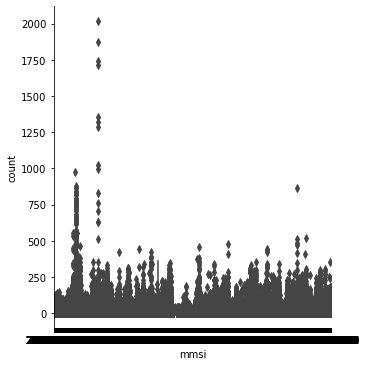

In [11]:
sns.catplot(x="mmsi",y="count", data=result, kind="box")

In [ ]:
re = result.loc[[result["count"].idxmax()]]

In [ ]:
re.to_csv("D:/AIS/Container_max.csv")

最大値の場所探し

In [ ]:
frame[(frame["mmsi"]==255805657)&(frame["dtg"]==dt.datetime(2018,12,9,18))]

In [ ]:
re[700:730]

In [ ]:
result.info()

In [ ]:
frame2 = frame.drop_duplicates(subset="mmsi")
print(frame2)
frame2.info()

隻数　(mmsi重複データ削除)

In [ ]:
frame3 = frame.sort_values("dtg")
print(frame3)

時間ソート